E: failed to import some OS environment variables, using defaults.
atmosphere:  accreting
n_params:  5
likelihood:  custom
machine:  local
num_energies:  128
sampling_params:  10
integrator: azimuthal_invariance_split
Rank reporting: 0
Setting channels for event data...
Channels set.
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.
Creating p

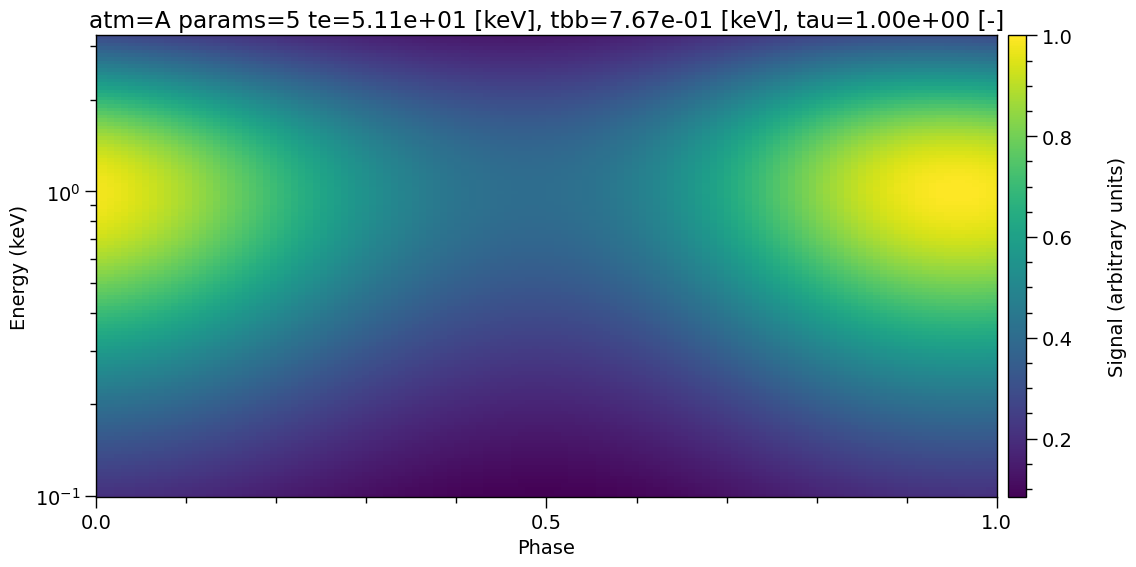

In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 10:35:05 2022

@author: bas
"""
# from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import rcParams
import matplotlib.pyplot as plt

import xpsi
from xpsi.global_imports import gravradius

################################ OPTIONS ###############################
second = False
te_index=0 # t__e = np.arange(40.0, 202.0, 4.0), there are 40.5 values (I expect that means 40)
tbb=0.001 #0.001 #0.001 - 0.003 # updated lower limit
te=40.#200 #40 - 200
tau=0.5 #0.5 - 3.5

hline = 1e-2
number_values = 20

atmosphere_type = os.environ.get('atmosphere_type')
n_params = os.environ.get('n_params')
likelihood_toggle = os.environ.get('likelihood') 
machine = os.environ.get('machine')
integrator_type = os.environ.get('integrator')

try:
    num_energies = int(os.environ.get('num_energies'))
    sampling_params = int(os.environ.get('sampling_params'))
except:
    pass


if isinstance(os.environ.get('atmosphere_type'),type(None)) or isinstance(os.environ.get('n_params'),type(None)) or isinstance(os.environ.get('likelihood'),type(None)) or isinstance(os.environ.get('machine'),type(None)) or isinstance(os.environ.get('num_energies'),type(None)) or isinstance(os.environ.get('sampling_params'),type(None)) or isinstance(os.environ.get('integrator'),type(None)): # if that fails input them here.
    print('E: failed to import some OS environment variables, using defaults.')    
    atmosphere_type = 'A' #A, N, B
    n_params = '5' #4, 5
    likelihood_toggle = 'custom' # default, custom
    machine = 'local' # local, helios, snellius
    num_energies = 128
    sampling_params=10
    integrator_type='x'


if atmosphere_type == 'A': atmosphere = 'accreting'
elif atmosphere_type == 'N': atmosphere = 'numerical'
elif atmosphere_type == 'B': atmosphere = 'blackbody'

if integrator_type == 'a': integrator = 'azimuthal_invariance'
elif integrator_type == 'x': integrator = 'azimuthal_invariance_split'
elif integrator_type == 'c': integrator = 'combined'
elif integrator_type == 's': integrator = 'split'
elif integrator_type == 'g': integrator = 'gsl'


print('atmosphere: ', atmosphere)
print('n_params: ', n_params)
print('likelihood: ', likelihood_toggle)
print('machine: ', machine)
print('num_energies: ', num_energies)
print('sampling_params: ', sampling_params)
print('integrator:', integrator)


this_directory = '/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/inference_run'

import sys
if machine == 'local':
    sys.path.append('/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/')
elif machine == 'helios':
    sys.path.append(this_directory+'/../')
elif machine == 'snellius':
    sys.path.append(this_directory+'/../')

from custom_tools import CustomInstrument, CustomInstrumentJ1808, CustomHotRegion, CustomHotRegion_Accreting, CustomHotRegion_Accreting_te_const
from custom_tools import CustomPhotosphere_BB, CustomPhotosphere_N4, CustomPhotosphere_N5, CustomPhotosphere_A5, CustomPhotosphere_A4
from custom_tools import CustomSignal, CustomPrior, CustomPrior_NoSecondary, plot_2D_pulse, CustomLikelihood

import time

np.random.seed(xpsi._rank+10)
print('Rank reporting: %d' % xpsi._rank)




##################################### DATA ####################################
if atmosphere_type=='A':
    exposure_time = 2e6#40000.
elif atmosphere_type=='N':
    exposure_time = 50000.

datastring = this_directory + '/../' + f'synthesise_pulse_data/data/J1808_synthetic_realisation.dat'        
channel_low = 20
channel_hi = 300 #600
max_input = 1400 #2000

settings = dict(counts = np.loadtxt(datastring, dtype=np.double),
                channels=np.arange(channel_low,channel_hi), #201
                phases=np.linspace(0.0, 1.0, 33),
                first=0, last=channel_hi-channel_low-1,
                exposure_time=exposure_time)

data = xpsi.Data(**settings)

################################## INSTRUMENT #################################



NICER = CustomInstrumentJ1808.from_response_files(ARF =  this_directory + '/../model_data/J1808/ni2584010103mpu7_arf_aeff.txt',
                                                  RMF =  this_directory + '/../model_data/J1808/ni2584010103mpu7_rmf_matrix.txt',
                                                  channel_edges =  this_directory + '/../model_data/J1808/ni2584010103mpu7_rmf_energymap.txt',
                                                  channel_low=channel_low,
                                                  channel_hi=channel_hi,
                                                  max_input=max_input)

# try:
#     if machine == 'local':
#         NICER = CustomInstrument.from_response_files(ARF = this_directory + '/../' + 'model_data/nicer_v1.01_arf.txt',
#                                                       RMF = this_directory + '/../' + 'model_data/nicer_v1.01_rmf_matrix.txt',
#                                                       max_input = 500, #500
#                                                       min_input = 0,
#                                                       channel_edges = this_directory + '/../' + 'model_data/nicer_v1.01_rmf_energymap.txt')
#     elif machine == 'helios' or machine == 'snellius':
#         NICER = CustomInstrument.from_response_files(ARF = this_directory +
#                                                       '/../' + 'model_data/nicer_v1.01_arf.txt',
#                                                       RMF = this_directory +
#                                                       '/../' + 'model_data/nicer_v1.01_rmf_matrix.txt',
#                                                       max_input = 500, #500
#                                                       min_input = 0,
#                                                       channel_edges =
#                                                       this_directory + '/../' +
#                                                       'model_data/nicer_v1.01_rmf_energymap.txt')   
# except:
#     print("ERROR: You might miss one of the following files (check Modeling tutorial or the link below how to find them): \n model_data/nicer_v1.01_arf.tx, model_data/nicer_v1.01_rmf_matrix.txt, model_data/nicer_v1.01_rmf_energymap.txt")
#     print("https://zenodo.org/record/7113931")
#     exit()


################################## SPACETIME ##################################

bounds = dict(distance = (0.1, 10.0),                       # (Earth) distance
                mass = (1.0, 3.0),                          # mass
                radius = (3.0 * gravradius(1.0), 16.0),     # equatorial radius
                cos_inclination = (0.0, 1.0))               # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=401.0))


################################## HOTREGIONS #################################
num_leaves = 128
sqrt_num_cells = 128
num_rays = 512
################################## PRIMARY ####################################
from xpsi import HotRegions

bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1))
values = {}

kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}

if atmosphere=='accreting':
    bounds['super_tbb'] = (0.001, 0.003)
    if n_params=='4':
        if sampling_params==8:
            values['super_tau'] = tau
        if sampling_params==9:
            bounds['super_tau'] = (0.5, 3.5)
        primary = CustomHotRegion_Accreting_te_const(bounds, values, **kwargs)
    if n_params=='5':
        if sampling_params==8:
            values['super_tau'] = tau
            values['super_te'] = te
        if sampling_params==9:
            bounds['super_tau'] = (0.5, 3.5)
            values['super_te'] = te  # I am not sure if you could or should switch te and tau here.
        if sampling_params==10: 
            bounds['super_tau'] = (0.5, 3.5)
            bounds['super_te'] = (40., 200.)
        primary = CustomHotRegion_Accreting(bounds, values, **kwargs)

elif atmosphere=='numerical':
    bounds['super_temperature'] = (5.1, 6.8)
    if n_params=='4':    
        primary = xpsi.HotRegion(bounds, values, **kwargs)
    elif n_params=='5':
        bounds['super_modulator'] = (-0.3, 0.3)
        kwargs['modulated'] = True
        primary = CustomHotRegion(bounds, values, **kwargs)

elif atmosphere=='blackbody':
    bounds['super_temperature'] = (5.1, 6.8)
    primary = xpsi.HotRegion(bounds, values, **kwargs)


###################################### SECONDARY ##############################
if second: # 4 doesn't work for secondary
    # If you derive bounds for a secondary hotspots, you cannot also define bounds
    # (above). You must set them to "None" to avoid some conflict. 

    if atmosphere=='accreting':
        bounds['super_tbb'] = None
        bounds['super_te'] = None
        bounds['super_tau'] = None
    if atmosphere=='numerical':
        bounds['super_temperature'] = None # declare fixed/derived variable
        bounds['super_modulator'] = None
    
    class derive(xpsi.Derive):
        def __init__(self):
            """
            We can pass a reference to the primary here instead
            and store it as an attribute if there is risk of
            the global variable changing.
    
            This callable can for this simple case also be
            achieved merely with a function instead of a magic
            method associated with a class.
            """
            pass
    
        def __call__(self, boundto, caller = None):
            # one way to get the required reference
            global primary # unnecessary, but for clarity
            return primary['super_temperature'] - 0.2
        
    class derive_modulator(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_modulator']  
    
    class derive_tbb(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            # print("super_tbb derive")
            # print(primary['super_tbb'])
            return primary['super_tbb']  
        
    class derive_te(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_te']  
    
    class derive_tau(xpsi.Derive):
        def __init__(self):
            pass
    
        def __call__(self, boundto, caller = None):
            global primary
            return primary['super_tau']  
        
    if atmosphere=='accreting':
        secondary = CustomHotRegion_Accreting(bounds=bounds, # can otherwise use same bounds
        	                      values={'super_tbb': derive_tbb(), 'super_te': derive_te(), 'super_tau': derive_tau()},
        	                      symmetry=False, #call general integrator instead of for azimuthal invariance
        	                      omit=False,
        	                      cede=False, 
        	                      concentric=False,
        	                      sqrt_num_cells=32,
        	                      min_sqrt_num_cells=10,
        	                      max_sqrt_num_cells=100,
        	                      num_leaves=100,
        	                      num_rays=200,
        	                      do_fast=False,
        	                      is_antiphased=True,
        	                      prefix='s')
    elif atmosphere=='numerical':
        secondary = CustomHotRegion(bounds=bounds, # can otherwise use same bounds
         	                      values={'super_temperature': derive(), 'super_modulator': derive_modulator()},
         	                      symmetry=False, #call general integrator instead of for azimuthal invariance
         	                      omit=False,
         	                      cede=False, 
         	                      concentric=False,
         	                      sqrt_num_cells=32,
         	                      min_sqrt_num_cells=10,
         	                      max_sqrt_num_cells=100,
         	                      num_leaves=100,
         	                      num_rays=200,
         	                      do_fast=False,
         	                      is_antiphased=True,
                                  modulated=True,
         	                      prefix='s')
    
    
    
    
    hot = HotRegions((primary, secondary))
    # h = hot.objects[0]
    # hot['p__super_temperature'] = 6.0 # equivalent to ``primary['super_temperature'] = 6.0``
    # print("printing hot:",hot)
elif not second:
    hot = HotRegions((primary,))
    
    
    
################################ ATMOSPHERE ################################### 
      

if atmosphere_type == 'A':
    if n_params == '4':
        photosphere = CustomPhotosphere_A4(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))   
        photosphere.te_index = te_index

    elif n_params == '5':
        photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
    if machine == 'local':
        photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    elif machine == 'helios' or machine == 'snellius':
        photosphere.hot_atmosphere = this_directory + '/../' + 'model_data/Bobrikova_compton_slab.npz'

elif atmosphere_type == 'N':
    if n_params == "4":   
        photosphere = CustomPhotosphere_N4(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
        photosphere.hot_atmosphere = this_directory + '/../' + 'model_data/nsx_H_v171019.npz'
    
    elif n_params== "5":
        photosphere = CustomPhotosphere_N5(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
        # photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_5D_no_effect.npz'
        photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_modulated_0dot5_to_2.npz'

elif n_params=="B":
    photosphere = CustomPhotosphere_BB(hot = hot, elsewhere = None, 
                                       values=dict(mode_frequency = spacetime['frequency']))

else:
    print("no photosphere could be created!")

################################### STAR ######################################

star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
# SAX J1808-like 
mass = 1.4
radius = 12.
distance = 3.5
inclination = 60
cos_inclination = math.cos(inclination*math.pi/180)
phase_shift = 0
super_colatitude = 20*math.pi/180
super_radius = 15.5*math.pi/180

p = [mass, #1.4, #grav mass
      radius,#12.5, #coordinate equatorial radius
      distance, # earth distance kpc
      cos_inclination, #cosine of earth inclination
      phase_shift, #phase of hotregion
      super_colatitude, #colatitude of centre of superseding region
      super_radius]  #angular radius superceding region

if atmosphere=='accreting':
    # Compton slab model parameters
    tbb=0.0015 #0.001 -0.003 Tbb(data) = Tbb(keV)/511keV, 1 keV = 0.002 data
    te=100. #40-200 corresponds to 20-100 keV (Te(data) = Te(keV)*1000/511keV), 50 keV = 100 data
    tau=1. #0.5 - 3.5 tau = ln(Fin/Fout)
    p += [tbb]
    if second:
        p += [te,
              tau,
              0.025, #phase shift
              math.pi - 1.0, #colatitude
              0.075 #angular radius
              ]
    elif not second:
        if n_params=='4':
            if sampling_params==8: p.append(tau)
        if n_params=='5':
            if sampling_params==9: p.append(tau)
            if sampling_params==10: p += [te, tau]

elif atmosphere=='numerical':   
    p_temperature=6.764 # 6.2    
    p += [p_temperature]
    if n_params == '5':
        modulator = 0 
        p += [modulator]    
        if second:
            p += [0.025, #phase shift
                  math.pi - 1.0, #colatitude
                  0.075] #angular radius    
            
elif atmosphere=='blackbody':
    p_temperature=6.2
    p += [p_temperature]
    if second:
        p += [0.025,
              math.pi - 1.0,
              0.025]

star(p)
star.update() 

print("printing Parameters of the star:")
print(star.params)



#################################### SIGNAL ###################################

signal = CustomSignal(data = data,
                        instrument = NICER,
                        background = None,
                        interstellar = None,
                        workspace_intervals = 1000,
                        cache = True,
                        epsrel = 1.0e-8,
                        epsilon = 1.0e-3,
                        sigmas = 10.0,
                        support = None)



##################################### PRIOR ##############################

if second:
    prior = CustomPrior()
elif not second:
    prior = CustomPrior_NoSecondary()

##################################### LIKELIHOOD ##############################
if likelihood_toggle == 'custom':
    print('use custom likelihood')
    likelihood = CustomLikelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)
elif likelihood_toggle == 'default':
    print('use default xpsi.likelihood')
    likelihood = xpsi.Likelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)


wrapped_params = [0]*len(likelihood)
wrapped_params[likelihood.index('p__phase_shift')] = 1
if second:
    wrapped_params[likelihood.index('s__phase_shift')] = 1

if machine == 'local':
    folderstring = f'local_runs/run_{atmosphere_type}{n_params}'
elif machine == 'helios':
    folderstring = f'helios_runs/run_{atmosphere_type}{n_params}{likelihood_toggle}'
elif machine == 'snellius':
    folderstring = f'snellius_runs/run_{atmosphere_type}{n_params}{likelihood_toggle}'

try: 
    os.makedirs(folderstring)
except OSError:
    if not os.path.isdir(folderstring):
        raise


if machine == 'local':
    sampling_efficiency = 0.3
    n_live_points = 25
    max_iter = 3
    outputfiles_basename = f'./{folderstring}/run_se={sampling_efficiency}_lp={n_live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iter}'
    runtime_params = {'resume': False,
                      'importance_nested_sampling': False,
                      'multimodal': False,
                      'n_clustering_params': None,
                      'outputfiles_basename': outputfiles_basename, 
                      'n_iter_before_update': 100,
                      'n_live_points': n_live_points,
                      'sampling_efficiency': sampling_efficiency,
                      'const_efficiency_mode': False,
                      'wrapped_params': wrapped_params,
                      'evidence_tolerance': 0.1,
                      'seed': 7,
                      'max_iter': max_iter, #-1, # manual termination condition for short test
                      'verbose': True}
if machine == 'helios':
    sampling_efficiency = 0.8
    n_live_points = 64
    max_iter = -1
    outputfiles_basename = f'./{folderstring}/run_se={sampling_efficiency}_lp={n_live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iter}'
    runtime_params = {'resume': False,
                      'importance_nested_sampling': False,
                      'multimodal': False,
                      'n_clustering_params': None,
                      'outputfiles_basename': outputfiles_basename, 
                      'n_iter_before_update': 50,
                      'n_live_points': n_live_points,
                      'sampling_efficiency': sampling_efficiency,
                      'const_efficiency_mode': False,
                      'wrapped_params': wrapped_params,
                      'evidence_tolerance': 0.5,
                      'seed': 7,
                      'max_iter': max_iter, # manual termination condition for short test
                      'verbose': True}
if machine == 'snellius':
    sampling_efficiency = 0.8
    n_live_points = 64
    max_iter = -1
    outputfiles_basename = f'./{folderstring}/run_se={sampling_efficiency}_lp={n_live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iter}'
    runtime_params = {'resume': False,
                      'importance_nested_sampling': False,
                      'multimodal': False,
                      'n_clustering_params': None,
                      'outputfiles_basename': outputfiles_basename,
                      'n_iter_before_update': 50,
                      'n_live_points': n_live_points,
                      'sampling_efficiency': sampling_efficiency,
                      'const_efficiency_mode': False,
                      'wrapped_params': wrapped_params,
                      'evidence_tolerance': 0.5,
                      'seed': 7,
                      'max_iter': max_iter, # manual termination condition for short test
                      'verbose': True}


try:
    true_logl = -7.94188579e+89 #-1.15566075e+05
    # print('about to evaluate likelihood')
    print("Compute likelikihood(p) once so the check passes. Likelihood = ", likelihood(p)) 
    likelihood.check(None, [true_logl], 1.0e-6,physical_points=[p])
except:
    print("Likelihood check did not pass. Checking if wrong atmosphere model installed.")
    true_logl = -3.27536126e+04
    print(likelihood(p))
    try:
        likelihood.check(None, [true_logl], 1.0e-6,physical_points=[p])
        print("Seems that blacbkody atmosphere extension was used instead of numerical.")
        print("Please re-install X-PSI using numerical atmosphere extension if want to use this test run.")
    except:
        print("Seems that neither of the likelihood checks passed, so something must be wrong.")

print('plotting...')
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

# random_draw = np.asarray([2.31408208e+00, 1.52255003e+01, 3.17410218e-01, 6.17105077e-01,4.68989205e-02, 1.43932885e-01, 1.46629707e+00, 2.30527925e-04,1.11742870e+02, 1.51992774e+00])
# likelihood(random_draw, reinitialise=True)


# Likelihood check and plot
if second:
    ax = plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
                  x=signal.phases[0],
                  shift=signal.shifts,
                  y=signal.energies,
                  ylabel=r'Energy (keV)')
if not second:
    # print('photosphere.signal[0][0]', photosphere.signal[0][0])
    ax = plot_2D_pulse((photosphere.signal[0][0],),
                  x=signal.phases[0],
                  shift=signal.shifts,
                  y=signal.energies,
                  ylabel=r'Energy (keV)')

if atmosphere=='accreting':
    if n_params=='4':
        ax.set_title('atm={} params={} te_index={}, tbb={:.2e} [keV], tau={:.2e} [-]'.format(atmosphere_type, n_params, te_index, tbb*511, tau), loc='center') #unit conversion te and tbb is different due to a cluster leftover according to Anna B.
        figstring = '{}/energies={}_atm={}_sec={}_te_index={}_tbb={:.2e}_tau={:.2e}.png'.format(folderstring, num_energies, atmosphere_type, second, te_index, tbb, tau)
    if n_params=='5':
        ax.set_title('atm={} params={} te={:.2e} [keV], tbb={:.2e} [keV], tau={:.2e} [-]'.format(atmosphere_type, n_params, te*0.511, tbb*511, tau), loc='center') #unit conversion te and tbb is different due to a cluster leftover according to Anna B.
        figstring = '{}/energies={}_atm={}_sec={}_te={:.2e}_tbb={:.2e}_tau={:.2e}.png'.format(folderstring, num_energies, atmosphere_type, second, te, tbb, tau)
elif atmosphere=='numerical':
    if n_params=="5":
        ax.set_title('n_params={} p_temperature={} modulator={}'.format(n_params, p_temperature, modulator))
        figstring='{}/5D_pulses_atm={}_sec={}_p_temperature={}_modulator={}.png'.format(folderstring, atmosphere, second, p_temperature, modulator)
    elif n_params=="4":
        ax.set_title('n_params={} p_temperature={}'.format(n_params, p_temperature))
        figstring='{}/energies={}_atm={}_sec={}_p_temperature={}.png'.format(folderstring, num_energies, atmosphere, second, p_temperature)
elif atmosphere=='blackbody':
    ax.set_title('n_params={} p_temperature={}'.format(n_params, p_temperature))
    figstring='{}/pulses_atm={}_sec={}_p_temperature={}.png'.format(folderstring, atmosphere, second, p_temperature)


plt.savefig(figstring)
print('figure saved in {}'.format(figstring))

# np.savetxt('signal/energies={}_integrator={}.txt'.format(num_energies,integrator),photosphere.signal[0][0])
import dill as pickle
with open(f'pulse/energies={num_energies}_integrator={integrator}.pkl', 'wb') as file:
    pickle.dump((photosphere.signal[0][0], signal.phases[0], signal.energies, signal.shifts), file)
    

print('hi res likelihood:',likelihood(p))

hi_res_ll = likelihood(p)



In [2]:
sqrt_num_cells_list = np.trunc(np.linspace(16,128,number_values))

loglikelihood_list_cells = []
deltatime_list_cells =  []

for sqrt_num_cells in sqrt_num_cells_list:
    num_leaves = 128
    num_rays = 512

    kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
              'omit': False,
              'cede': False,
              'concentric': False,
              'sqrt_num_cells': sqrt_num_cells,
              'min_sqrt_num_cells': 10,
              'max_sqrt_num_cells': 128,#64,
              'num_leaves': num_leaves,
              'num_rays': num_rays,
              'prefix': 'p'}
    
    primary = CustomHotRegion_Accreting(bounds, values, **kwargs)
    
    hot = HotRegions((primary,))
    photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
    star(p)
    star.update()
    likelihood = CustomLikelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)
    likelihood.star.photospheres[0].hot.print_settings()
    likelihood(p)
    # print(likelihood.ldict)
    deltatime_list_cells.append(likelihood.ldict[0]['deltatime'])
    loglikelihood_list_cells.append(likelihood.ldict[0]['loglikelihood'])
    print(likelihood.ldict[0]['deltatime'])
    print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff_cells = loglikelihood_list_cells-np.ones(len(loglikelihood_list_cells))*hi_res_ll


Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  16
Number of rays per pa

Base number of cell parallels:  51
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 0.885 seconds
0.8851566314697266
-55768.87486586155
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the 

Base number of cell parallels:  86
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 2.184 seconds
2.1837635040283203
-55768.76366006647
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the 

Base number of cell parallels:  122
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 3.034 seconds
3.0337727069854736
-55768.74118721741
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the

Text(0.5, 0, 'checktime (s)')

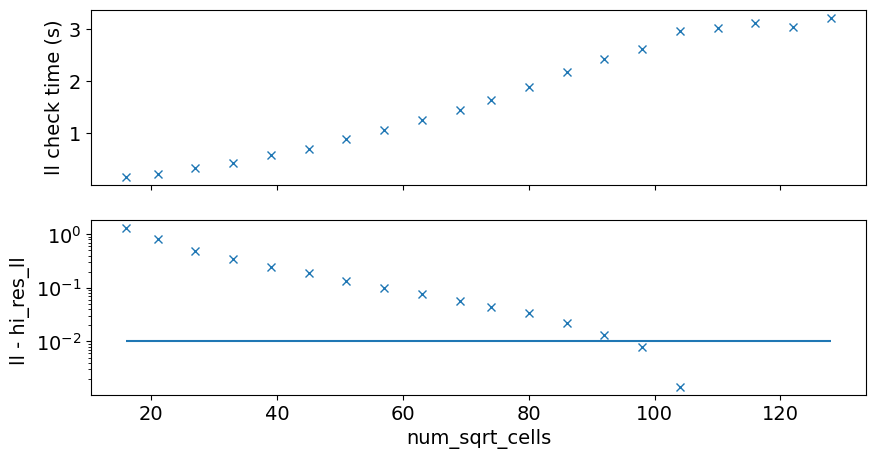

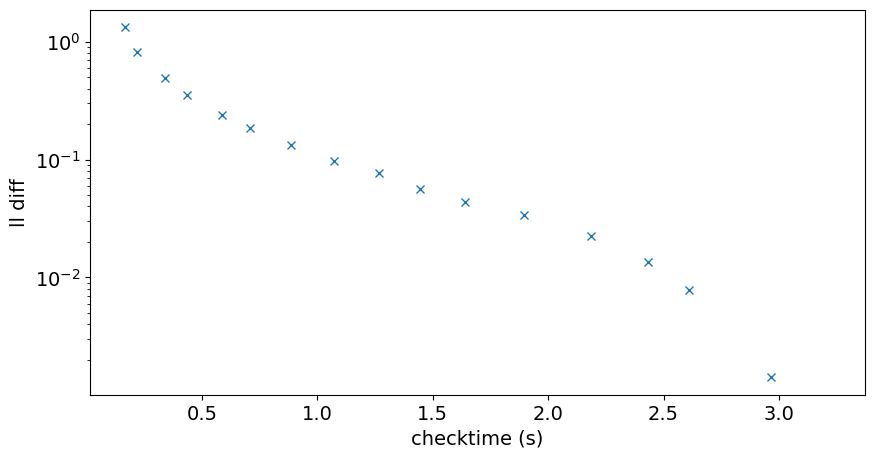

In [32]:
fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)

axes[0].plot(sqrt_num_cells_list, deltatime_list_cells,'x')
axes[0].set_ylabel('ll check time (s)')

axes[1].semilogy(sqrt_num_cells_list, abs(loglikelihood_diff_cells),'x')
axes[1].set_xlabel('num_sqrt_cells')
axes[1].set_ylabel('ll - hi_res_ll ')
axes[1].hlines(hline,16,128)


fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(deltatime_list_cells, abs(loglikelihood_diff_cells),'x')
ax.set_ylabel('ll diff')
ax.set_xlabel('checktime (s)')

In [4]:
num_leaves_list = np.trunc(np.linspace(16,128,number_values))

loglikelihood_list_leaves = []
deltatime_list_leaves =  []

for num_leaves in num_leaves_list:
    sqrt_num_cells = 128
    num_rays = 512

    kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
              'omit': False,
              'cede': False,
              'concentric': False,
              'sqrt_num_cells': sqrt_num_cells,
              'min_sqrt_num_cells': 10,
              'max_sqrt_num_cells': 128,
              'num_leaves': num_leaves,
              'num_rays': num_rays,
              'prefix': 'p'}
    
    primary = CustomHotRegion_Accreting(bounds, values, **kwargs)
    
    hot = HotRegions((primary,))
    photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
    star(p)
    star.update()
    likelihood = CustomLikelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)
    likelihood.star.photospheres[0].hot.print_settings()
    likelihood(p)
    # print(likelihood.ldict)
    deltatime_list_leaves.append(likelihood.ldict[0]['deltatime'])
    loglikelihood_list_leaves.append(likelihood.ldict[0]['loglikelihood'])
    print(likelihood.ldict[0]['deltatime'])
    print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff_leaves = loglikelihood_list_leaves-np.ones(len(loglikelihood_list_leaves))*hi_res_ll

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  128
Number of rays per p

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  51
Number of interpolation phases:  51
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 1.348 seconds
1.3479118347167969
-55768.73728099477
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  86
Number of interpolation phases:  86
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 2.093 seconds
2.0932552814483643
-55768.7430056124
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (c

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  122
Number of interpolation phases:  122
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 3.193 seconds
3.192566394805908
-55768.7410721046
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (

Text(0.5, 0, 'checktime (s)')

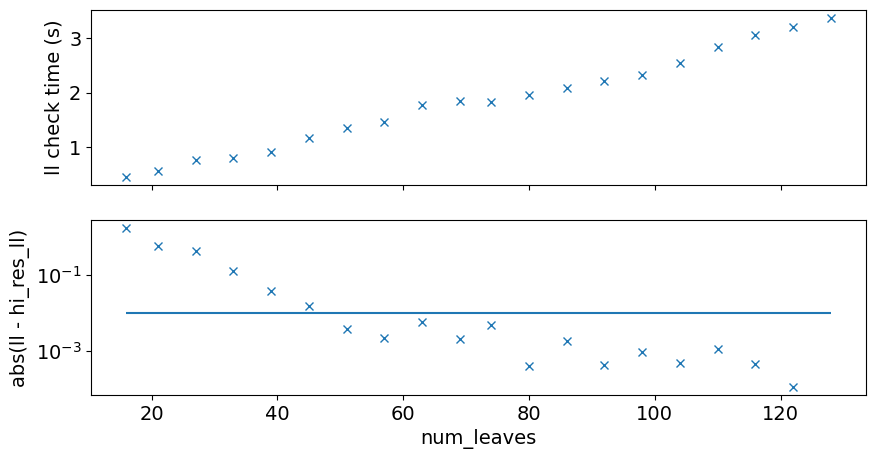

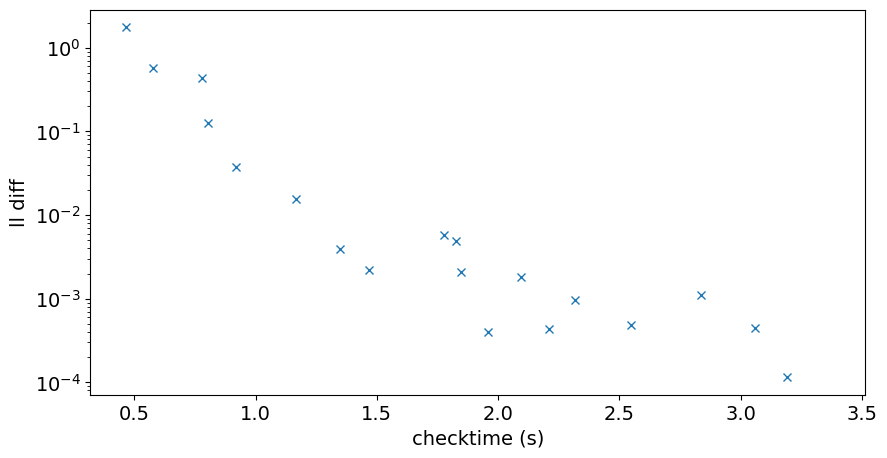

In [33]:
fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)

axes[0].plot(num_leaves_list, deltatime_list_leaves,'x')
axes[0].set_ylabel('ll check time (s)')

axes[1].semilogy(num_leaves_list, abs(loglikelihood_diff_leaves),'x')
axes[1].set_xlabel('num_leaves')
axes[1].set_ylabel('abs(ll - hi_res_ll)')
axes[1].hlines(hline,16,128)


fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(deltatime_list_leaves, abs(loglikelihood_diff_leaves),'x')
ax.set_ylabel('ll diff')
ax.set_xlabel('checktime (s)')

num_rays_list = np.(np.logspace(4,9,50, base=2.))

loglikelihood_list_rays = []
deltatime_list_rays =  []

for num_rays in num_rays_list:
    sqrt_num_cells = 128
    num_leaves = 128

    kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
              'omit': False,
              'cede': False,
              'concentric': False,
              'sqrt_num_cells': sqrt_num_cells,
              'min_sqrt_num_cells': 10,
              'max_sqrt_num_cells': 128,
              'num_leaves': num_leaves,
              'num_rays': num_rays,
              'prefix': 'p'}
    
    primary = CustomHotRegion_Accreting(bounds, values, **kwargs)
    
    hot = HotRegions((primary,))
    photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
    star(p)
    star.update()
    likelihood = CustomLikelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)
    likelihood.star.photospheres[0].hot.print_settings()
    likelihood(p)
    # print(likelihood.ldict)
    deltatime_list_rays.append(likelihood.ldict[0]['deltatime'])
    loglikelihood_list_rays.append(likelihood.ldict[0]['loglikelihood'])
    print(likelihood.ldict[0]['deltatime'])
    print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff_rays = loglikelihood_list_rays-np.ones(len(loglikelihood_list_rays))*hi_res_ll

fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)

axes[0].plot(num_rays_list, deltatime_list_rays,'x')
axes[0].set_ylabel('ll check time (s)')

axes[1].semilogy(num_rays_list, abs(loglikelihood_diff_rays),'x')
axes[1].set_xlabel('num_rays')
axes[1].set_ylabel('abs(ll - hi_res_ll)')
axes[1].hlines(hline,16,128)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(deltatime_list_rays, abs(loglikelihood_diff_rays),'x')
ax.hlines(hline,0.2,1)
ax.set_ylabel('ll diff')
ax.set_xlabel('checktime (s)')

In [6]:
num_energies_list = np.trunc(np.linspace(16,128,number_values))

loglikelihood_list_energies = []
deltatime_list_energies =  []

for num_energies in num_energies_list:
    sqrt_num_cells = 128
    num_leaves = 128
    num_rays = 512

    kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
              'omit': False,
              'cede': False,
              'concentric': False,
              'sqrt_num_cells': sqrt_num_cells,
              'min_sqrt_num_cells': 10,
              'max_sqrt_num_cells': 128,
              'num_leaves': num_leaves,
              'num_rays': num_rays,
              'prefix': 'p'}
    
    primary = CustomHotRegion_Accreting(bounds, values, **kwargs)
    
    hot = HotRegions((primary,))
    photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                    values=dict(mode_frequency = spacetime['frequency']))
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
    star(p)
    star.update()
    likelihood = CustomLikelihood(star = star, signals = signal,
                                  num_energies=num_energies, #128
                                  threads=1,
                                  prior=prior,
                                  externally_updated=True)
    likelihood.star.photospheres[0].hot.print_settings()
    likelihood(p)
    # print(likelihood.ldict)
    deltatime_list_energies.append(likelihood.ldict[0]['deltatime'])
    loglikelihood_list_energies.append(likelihood.ldict[0]['loglikelihood'])
    print(likelihood.ldict[0]['deltatime'])
    print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff_energies = loglikelihood_list_energies-np.ones(len(loglikelihood_list_energies))*hi_res_ll

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  128
Number of rays per p

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 1.418 seconds
1.4175238609313965
-55768.73416355497
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 2.154 seconds
2.154355049133301
-55768.7385763707
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (

Base number of cell parallels:  128
Number of rays per parallel:  512
Number of photospheric leaves:  128
Number of interpolation phases:  128
attempting to photosphere.integrate. threads:  1
photosphere done
register the signals by operating with the instrument response
update star
reregistered True
not synthesise
call signal inside likelihood driver
likelihood driver done
Likelihood evaluation took 3.250 seconds
3.2502527236938477
-55768.74137176649
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the

Text(0.5, 0, 'checktime (s)')

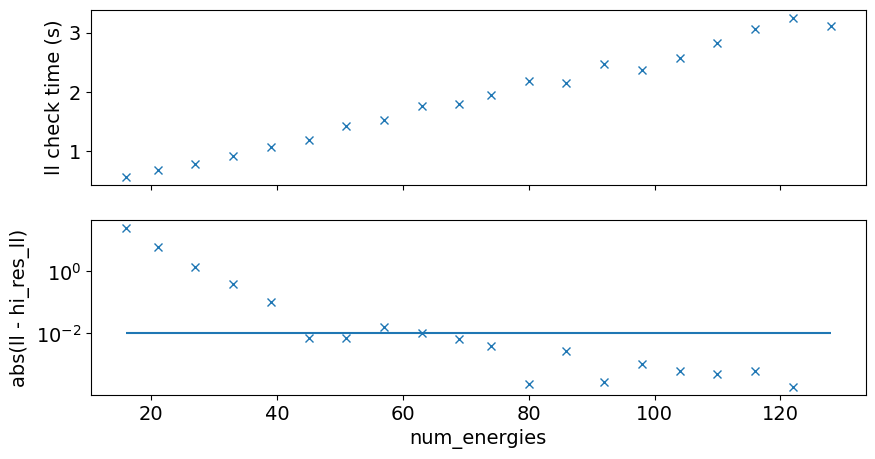

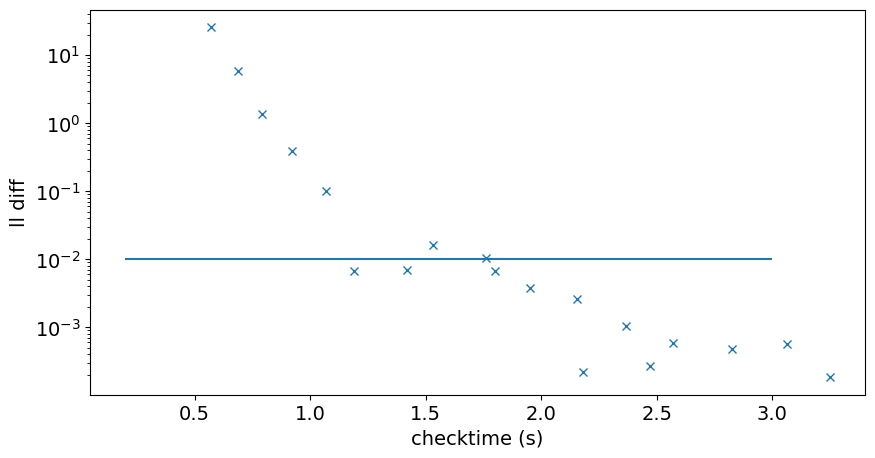

In [34]:
fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)

axes[0].plot(num_energies_list, deltatime_list_energies,'x')
axes[0].set_ylabel('ll check time (s)')

axes[1].semilogy(num_energies_list, abs(loglikelihood_diff_energies),'x')
axes[1].set_xlabel('num_energies')
axes[1].set_ylabel('abs(ll - hi_res_ll)')
axes[1].hlines(hline,16,128)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(deltatime_list_energies, abs(loglikelihood_diff_energies),'x')
ax.hlines(hline,0.2,3)
ax.set_ylabel('ll diff')
ax.set_xlabel('checktime (s)')

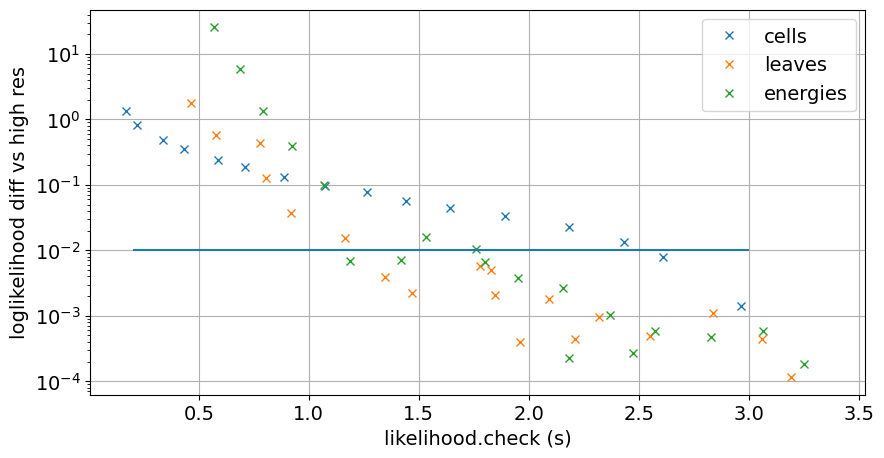

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(deltatime_list_cells, abs(loglikelihood_diff_cells),'x', label='cells')
ax.semilogy(deltatime_list_leaves, abs(loglikelihood_diff_leaves),'x', label='leaves')
#ax.semilogy(deltatime_list_rays, abs(loglikelihood_diff_rays),'x', label='rays')
ax.semilogy(deltatime_list_energies, abs(loglikelihood_diff_energies),'x', label='energies')
ax.hlines(hline,0.2,3)

ax.set_ylabel('loglikelihood diff vs high res')
ax.set_xlabel('likelihood.check (s)')
ax.legend()
plt.grid(True)

In [28]:
num_energies = 100
sqrt_num_cells = 128
num_leaves = 110
num_rays = 512

kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}

primary = CustomHotRegion_Accreting(bounds, values, **kwargs)

hot = HotRegions((primary,))
photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))
photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
star(p)
star.update()
likelihood = CustomLikelihood(star = star, signals = signal,
                              num_energies=num_energies, #128
                              threads=1,
                              prior=prior,
                              externally_updated=True)
likelihood.star.photospheres[0].hot.print_settings()
likelihood(p)


print(likelihood.ldict[0]['deltatime'])
print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff = likelihood.ldict[0]['loglikelihood']-hi_res_ll
print(loglikelihood_diff)

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  128
Number of rays per p

In [29]:
num_energies = 60
sqrt_num_cells = 90
num_leaves = 50
num_rays = 512

kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}

primary = CustomHotRegion_Accreting(bounds, values, **kwargs)

hot = HotRegions((primary,))
photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))
photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
star(p)
star.update()
likelihood = CustomLikelihood(star = star, signals = signal,
                              num_energies=num_energies, #128
                              threads=1,
                              prior=prior,
                              externally_updated=True)
likelihood.star.photospheres[0].hot.print_settings()
likelihood(p)


print(likelihood.ldict[0]['deltatime'])
print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff = likelihood.ldict[0]['loglikelihood']-hi_res_ll
print(loglikelihood_diff)

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  90
Number of rays per pa

In [30]:
num_energies = 40
sqrt_num_cells = 50
num_leaves = 30
num_rays = 512

kwargs = {'symmetry': integrator, #call general integrator instead of for azimuthal invariance
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}

primary = CustomHotRegion_Accreting(bounds, values, **kwargs)

hot = HotRegions((primary,))
photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))
photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
star(p)
star.update()
likelihood = CustomLikelihood(star = star, signals = signal,
                              num_energies=num_energies, #128
                              threads=1,
                              prior=prior,
                              externally_updated=True)
likelihood.star.photospheres[0].hot.print_settings()
likelihood(p)


print(likelihood.ldict[0]['deltatime'])
print(likelihood.ldict[0]['loglikelihood'])
    
loglikelihood_diff = likelihood.ldict[0]['loglikelihood']-hi_res_ll
print(loglikelihood_diff)

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Base number of cell parallels:  50
Number of rays per pa